# 모델 저장

- 학습한 모델을 저장장치에 파일로 저장하고 나중에 불러와 사용(추가 학습, 예측 서비스) 할 수 있도록 한다. 
- 파이토치는 모델의 파라미터만 저장하는 방법과 모델 구조와 파라미터 모두를 저장하는 두가지 방식을 제공한다.
- 저장 함수
    - `torch.save(저장할 객체, 저장경로)`
- 보통 저장파일의 확장자는 `pt`나 `pth` 를 지정한다.

## 모델 전체 저장하기 및 불러오기

- 저장하기
    - `torch.save(model, 저장경로)`
- 불러오기
    - `load_model = torch.load(저장경로)`
- 저장시 **pickle**을 이용해 직렬화하기 때문에 불어오는 실행환경에도 모델을 저장할 때 사용한 클래스가 있어야 한다.



## 모델의 파라미터만 저장
- 모델을 구성하는 파라미터만 저장한다.
- 모델의 구조는 저장하지 않기 때문에 불러올 때 **모델을 먼저 생성하고 생성한 모델에 불러온 파라미터를 덮어씌운다.**
- 모델의 파라미터는 **state_dict** 형식으로 저장한다.

### state_dict
- 모델의 파라미터 Tensor들을 레이어 단위별로 나누어 저장한 Ordered Dictionary (OrderedDict)
- `모델객체.state_dict()` 메소드를 이용해 조회한다.
- 모델의 state_dict을 조회 후 저장한다.
    - `torch.save(model.state_dict(), "저장경로")`
- 생성된 모델에 읽어온 state_dict를 덮어씌운다.
    - `new_model.load_state_dict(torch.load("state_dict저장경로"))`


In [2]:
import torch
import torch.nn as nn

class Network(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.in_layer = nn.Linear(784, 64)
        self.out = nn.Linear(64, 10)
    
    def forward(self, X):
        X = torch.flatten(X, start_dim=1)
        X = nn.ReLU()(self.in_layer(X))
        X = self.out(X)
        return X

In [3]:
sample_model = Network()
sample_model

Network(
  (in_layer): Linear(in_features=784, out_features=64, bias=True)
  (out): Linear(in_features=64, out_features=10, bias=True)
)

In [6]:
# state_dict 조회
sd = sample_model.state_dict()
print(type(sd))
sd.keys()

<class 'collections.OrderedDict'>


odict_keys(['in_layer.weight', 'in_layer.bias', 'out.weight', 'out.bias'])

In [10]:
sd['in_layer.weight'].shape, sd['in_layer.bias'].shape

(torch.Size([64, 784]), torch.Size([64]))

In [12]:
sample_model.parameters()

<generator object Module.parameters at 0x000001FDFEC2F1B0>

In [17]:
sample_model.in_layer.weight
sample_model.in_layer.bias

Parameter containing:
tensor([ 0.0101,  0.0306, -0.0164,  0.0321, -0.0119,  0.0323,  0.0212, -0.0171,
        -0.0073, -0.0351,  0.0132,  0.0166, -0.0245, -0.0214,  0.0279, -0.0108,
        -0.0248,  0.0193, -0.0216, -0.0066, -0.0010, -0.0283, -0.0340,  0.0041,
        -0.0054, -0.0333, -0.0097, -0.0122, -0.0289, -0.0154, -0.0025, -0.0081,
        -0.0186,  0.0063, -0.0092, -0.0047, -0.0262, -0.0220,  0.0330,  0.0064,
        -0.0155, -0.0262,  0.0228, -0.0118, -0.0217,  0.0313, -0.0102,  0.0343,
         0.0271,  0.0144,  0.0318,  0.0012, -0.0118,  0.0072, -0.0020,  0.0168,
        -0.0297,  0.0301, -0.0074, -0.0079,  0.0264, -0.0033,  0.0261, -0.0161],
       requires_grad=True)

# Checkpoint를 저장 및 불러오기
- 학습이 끝나지 않은 모델을 저장 후 나중에 이어서 학습시킬 경우에는 모델의 구조, 파라미터 뿐만 아니라 optimizer, loss 함수등 학습에 필요한 객체들을 저장해야 한다.
- Dictionary에 필요한 요소들을 key-value 쌍으로 저장후 `torch.save()`를 이용해 저장한다.
```python
# 저장
torch.save({
    'epoch':epoch,
    'model_state_dict':model.state_dict(),
    'optimizer_state_dict':optimizer.state_dict(),
    'loss':train_loss
}, "저장경로")

# 불러오기
model = MyModel()
optimizer = optim.Adam(model.parameter())

checkpoint = torch.load("저장경로")
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict])
epoch = checkpoint['epoch']
loss = checkpoint['loss']

#### 이어학습
model.train()
#### 추론
model.eval()

```

# 문제 유형별 MLP 네트워크
- MLP(Multi Layer Perceptron)
    - Fully Connected Layer로 구성된 네트워크

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import torchinfo


from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

device = "cuda" if torch.cuda.is_available() else "cpu"
# device = "mps" if torch.backends.mps.is_available() else "cpu"
print(device)

cpu


# Regression(회귀)

## Boston Housing Dataset
보스턴 주택가격 dataset은 다음과 같은 속성을 바탕으로 해당 타운 주택 가격의 중앙값을 예측하는 문제.
- CRIM: 범죄율
- ZN: 25,000 평방피트당 주거지역 비율
- INDUS: 비소매 상업지구 비율
- CHAS: 찰스강에 인접해 있는지 여부(인접:1, 아니면:0)
- NOX: 일산화질소 농도(단위: 0.1ppm)
- RM: 주택당 방의 수
- AGE: 1940년 이전에 건설된 주택의 비율
- DIS: 5개의 보스턴 직업고용센터와의 거리(가중 평균)
- RAD: 고속도로 접근성
- TAX: 재산세율
- PTRATIO: 학생/교사 비율
- B: 흑인 비율
- LSTAT: 하위 계층 비율
<br><br>
- **Target**
    - MEDV: 타운의 주택가격 중앙값(단위: 1,000달러)

## Dataset, DataLoader 생성

In [20]:
boston = pd.read_csv('boston_hosing.csv')
boston.shape

X_boston = boston.drop(columns='MEDV').values
y_boston = boston['MEDV'].values.reshape(-1, 1) # 2차원
X_boston.shape, y_boston.shape

((506, 13), (506, 1))

In [ ]:
# train/test set 분리
X_train, X_test, y_train, y_test = train_test_split(X_boston, y_boston,
                                                    test_size=0.2, random_state=0)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

In [23]:
# feature scaling 
scaler = StandardScaler()
X_train_scaled = torch.tensor(scaler.fit_transform(X_train), dtype=torch.float32)
X_test_scaled = torch.tensor(scaler.transform(X_test), dtype=torch.float32)
# y를 Tensor 타입으로 변환.
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

In [27]:
# Dataset
boston_train_set = TensorDataset(X_train_scaled, y_train_tensor)
boston_test_set = TensorDataset(X_test_scaled, y_test_tensor)
print(len(boston_train_set), len(boston_test_set))
print(boston_train_set[0])

# DataLoader
boston_train_loader = DataLoader(boston_train_set, batch_size=200, 
                                 shuffle=True, drop_last=True)
boston_test_loader = DataLoader(boston_test_set, batch_size=len(boston_test_set))
len(boston_train_loader), len(boston_test_loader)  # epoch 당 step 수 

404 102
(tensor([-0.3726, -0.4996, -0.7049,  3.6645, -0.4249,  0.9357,  0.6937, -0.4372,
        -0.1622, -0.5617, -0.4846,  0.3717, -0.4110]), tensor([26.7000]))


(2, 1)

## 모델 정의

In [28]:
X_boston.shape

(506, 13)

In [32]:
class BostonModel(nn.Module):
    
    def __init__(self):
        super().__init__()
        # 입력 layer => in_feature: input data의 feature개수에 맞춘다.
        self.lr1 = nn.Linear(13, 32)   # input
        # Hidden layer => in_feature: 앞 Layer의 out_feature 개수에 맞춘다.
        self.lr2 = nn.Linear(32, 16)  
        # output layer => out_feature: 모델의 최종 출력 개수에 맞춘다. (집값 1개->1)
        self.lr3 = nn.Linear(16, 1)
    
        
    def forward(self, X):
        # input layer
        out = self.lr1(X)
        out = nn.ReLU()(out)
        # hidden
        out = self.lr2(out)
        out = nn.ReLU()(out)
        # output -> 회귀처리 모델에서 output layer에서는 활성함수를 적용하지 않는다.
        #   예외: 출력결과가 특정 활성함수의 출력과 매칭될 경우.
        #        output: 0 ~ 1 => logistic 함수사용.
        #        output: -1 ~ 1=> hyperbolic tangent (tanh)
        out  = self.lr3(out)
        return out

In [34]:
boston_model = BostonModel()
torchinfo.summary(boston_model, (200, 13))  #(모델, 입력데이터shape-(batch size, feature) )

Layer (type:depth-idx)                   Output Shape              Param #
BostonModel                              [200, 1]                  --
├─Linear: 1-1                            [200, 32]                 448
├─Linear: 1-2                            [200, 16]                 528
├─Linear: 1-3                            [200, 1]                  17
Total params: 993
Trainable params: 993
Non-trainable params: 0
Total mult-adds (M): 0.20
Input size (MB): 0.01
Forward/backward pass size (MB): 0.08
Params size (MB): 0.00
Estimated Total Size (MB): 0.09

## 학습

In [40]:
N_EPOCH = 1000
LR = 0.001
# 결과 저장할 리스트
train_loss_list = []
val_loss_list = []

# 모델, loss함수(회귀-MSE), optimizer
boston_model = BostonModel()
boston_model = boston_model.to(device)
loss_fn = nn.MSELoss()
optimizer = torch.optim.RMSprop(boston_model.parameters(), lr=LR)

In [41]:
# 학습: 두단계 - 학습 + 검증
for epoch in range(N_EPOCH):
    ################
    # 학습 - 모델을 train 모드로 변경
    ################
    boston_model.train()
    train_loss = 0.0
    for X, y in boston_train_loader:
        # X, y를 device로 이동
        X, y = X.to(device), y.to(device)
        # 1. 모델 추정
        pred = boston_model(X) # 순전파(forward propagation)
        # 2. loss 계산
        loss = loss_fn(pred, y)  # 추정, 정답
        # 3. 모델 파라미터를 업데이트
        ## 3.1 파라미터들의 기울기를 초기화
        optimizer.zero_grad()
        ## 3.2 역전파(back propagration)을 해서 파라미터들의 기울기를 계산(grad속성에 저장)
        loss.backward()
        ## 3.3 파라미터 업데이트 처리.=> 1 step
        optimizer.step()
        
        train_loss += loss.item()
    #평균 loss
    train_loss /= len(boston_train_loader)
    # 1 epoch 학습끝
    ###############################
    # 검증 - 모델을 평가모드로 변경
    ###############################
    boston_model.eval() #evalutation mode 로 변환
    val_loss = 0.0
    # 역전파를 통한 gradient 계산이 필요 없기 때문에 일시적으로 grad_fn 을 구하지 않도록 처리.
    with torch.no_grad():
        for X_val, y_val in boston_test_loader:
            X_val, y_val = X_val.to(device), y_val.to(device)
            # 1.추정
            pred_val = boston_model(X_val)
            # 2. loss 계산
            val_loss += loss_fn(pred_val, y_val).item()
        val_loss /= len(boston_test_loader)
    # epoch에 대한 검증 완료
    # 결과 출력
    print(f"[{epoch+1}/{N_EPOCH}] train loss: {train_loss:.5f}, val loss: {val_loss:.5f}")
    train_loss_list.append(train_loss)
    val_loss_list.append(val_loss)

[1/1000] train loss: 594.37888, val loss: 570.43408
[2/1000] train loss: 588.66394, val loss: 562.88055
[3/1000] train loss: 578.88843, val loss: 554.63916
[4/1000] train loss: 570.28241, val loss: 545.62061
[5/1000] train loss: 566.16193, val loss: 535.91327
[6/1000] train loss: 548.04317, val loss: 525.59784
[7/1000] train loss: 544.15288, val loss: 514.36932
[8/1000] train loss: 533.58899, val loss: 502.53384
[9/1000] train loss: 520.16202, val loss: 490.04745
[10/1000] train loss: 503.44720, val loss: 477.12799
[11/1000] train loss: 491.97881, val loss: 463.80646
[12/1000] train loss: 477.20920, val loss: 450.13510
[13/1000] train loss: 462.22078, val loss: 436.23578
[14/1000] train loss: 444.92764, val loss: 422.03226
[15/1000] train loss: 432.14780, val loss: 407.62064
[16/1000] train loss: 415.96544, val loss: 393.07483
[17/1000] train loss: 398.83139, val loss: 378.47281
[18/1000] train loss: 383.42761, val loss: 363.88638
[19/1000] train loss: 368.05484, val loss: 349.37817
[2

[188/1000] train loss: 14.03581, val loss: 29.85709
[189/1000] train loss: 13.43996, val loss: 29.75305
[190/1000] train loss: 13.95107, val loss: 29.69041
[191/1000] train loss: 13.42567, val loss: 29.68712
[192/1000] train loss: 13.74028, val loss: 29.57350
[193/1000] train loss: 13.67047, val loss: 29.48989
[194/1000] train loss: 13.55108, val loss: 29.29179
[195/1000] train loss: 13.52221, val loss: 29.23738
[196/1000] train loss: 13.50324, val loss: 29.07234
[197/1000] train loss: 13.39694, val loss: 29.00282
[198/1000] train loss: 13.38988, val loss: 28.90586
[199/1000] train loss: 13.27199, val loss: 28.76713
[200/1000] train loss: 13.24864, val loss: 28.72983
[201/1000] train loss: 13.17902, val loss: 28.60137
[202/1000] train loss: 13.08836, val loss: 28.50629
[203/1000] train loss: 13.09205, val loss: 28.39671
[204/1000] train loss: 13.07368, val loss: 28.25850
[205/1000] train loss: 12.96353, val loss: 28.17633
[206/1000] train loss: 12.82444, val loss: 28.03016
[207/1000] t

[369/1000] train loss: 7.60804, val loss: 20.66871
[370/1000] train loss: 7.54912, val loss: 20.60338
[371/1000] train loss: 7.62600, val loss: 20.82917
[372/1000] train loss: 7.58908, val loss: 20.41633
[373/1000] train loss: 7.51596, val loss: 20.56753
[374/1000] train loss: 7.54869, val loss: 20.52883
[375/1000] train loss: 7.57290, val loss: 20.34956
[376/1000] train loss: 7.47508, val loss: 20.49363
[377/1000] train loss: 7.24138, val loss: 20.58097
[378/1000] train loss: 7.43049, val loss: 20.48440
[379/1000] train loss: 7.44113, val loss: 20.34090
[380/1000] train loss: 7.43820, val loss: 20.29401
[381/1000] train loss: 7.47553, val loss: 20.45416
[382/1000] train loss: 7.42168, val loss: 20.62436
[383/1000] train loss: 7.42469, val loss: 20.37425
[384/1000] train loss: 7.49128, val loss: 20.38163
[385/1000] train loss: 7.48760, val loss: 20.17632
[386/1000] train loss: 7.30771, val loss: 20.30191
[387/1000] train loss: 7.26711, val loss: 20.40251
[388/1000] train loss: 7.39609,

[539/1000] train loss: 5.87677, val loss: 18.62009
[540/1000] train loss: 5.92120, val loss: 18.64030
[541/1000] train loss: 5.58653, val loss: 18.84785
[542/1000] train loss: 5.82917, val loss: 18.63009
[543/1000] train loss: 5.80379, val loss: 18.73122
[544/1000] train loss: 5.79611, val loss: 18.79180
[545/1000] train loss: 5.80332, val loss: 18.60736
[546/1000] train loss: 5.78727, val loss: 18.72855
[547/1000] train loss: 5.80943, val loss: 18.45576
[548/1000] train loss: 5.82752, val loss: 18.43685
[549/1000] train loss: 5.76200, val loss: 18.58054
[550/1000] train loss: 5.69265, val loss: 18.64350
[551/1000] train loss: 5.44366, val loss: 18.65419
[552/1000] train loss: 5.74092, val loss: 18.56622
[553/1000] train loss: 5.81909, val loss: 18.50211
[554/1000] train loss: 5.89867, val loss: 18.33023
[555/1000] train loss: 5.79794, val loss: 18.45414
[556/1000] train loss: 5.90812, val loss: 18.82593
[557/1000] train loss: 5.76738, val loss: 18.68765
[558/1000] train loss: 5.78983,

[710/1000] train loss: 4.93367, val loss: 17.54746
[711/1000] train loss: 4.95557, val loss: 17.91472
[712/1000] train loss: 4.82547, val loss: 17.86888
[713/1000] train loss: 4.88253, val loss: 17.55740
[714/1000] train loss: 4.95272, val loss: 17.84825
[715/1000] train loss: 5.03406, val loss: 17.60475
[716/1000] train loss: 4.97201, val loss: 17.72867
[717/1000] train loss: 4.92281, val loss: 17.84910
[718/1000] train loss: 4.93288, val loss: 17.90830
[719/1000] train loss: 4.98112, val loss: 17.80557
[720/1000] train loss: 4.92837, val loss: 17.80976
[721/1000] train loss: 5.02506, val loss: 18.15514
[722/1000] train loss: 4.99658, val loss: 17.48354
[723/1000] train loss: 5.00025, val loss: 17.58223
[724/1000] train loss: 4.98544, val loss: 17.52023
[725/1000] train loss: 4.87955, val loss: 17.66625
[726/1000] train loss: 4.80672, val loss: 17.69999
[727/1000] train loss: 4.89564, val loss: 17.67380
[728/1000] train loss: 4.91108, val loss: 17.89026
[729/1000] train loss: 4.87545,

[891/1000] train loss: 4.38095, val loss: 17.55646
[892/1000] train loss: 4.34498, val loss: 17.37203
[893/1000] train loss: 4.32068, val loss: 17.44959
[894/1000] train loss: 4.34863, val loss: 17.59552
[895/1000] train loss: 4.37120, val loss: 17.32354
[896/1000] train loss: 4.33419, val loss: 17.32356
[897/1000] train loss: 4.37318, val loss: 17.46570
[898/1000] train loss: 4.26696, val loss: 17.63577
[899/1000] train loss: 4.25540, val loss: 17.56383
[900/1000] train loss: 4.30632, val loss: 17.27955
[901/1000] train loss: 4.40951, val loss: 17.46954
[902/1000] train loss: 4.31255, val loss: 17.55950
[903/1000] train loss: 4.29405, val loss: 17.42506
[904/1000] train loss: 4.30637, val loss: 17.58564
[905/1000] train loss: 4.30498, val loss: 17.72968
[906/1000] train loss: 4.36319, val loss: 17.61466
[907/1000] train loss: 4.18989, val loss: 17.49767
[908/1000] train loss: 4.27131, val loss: 17.35843
[909/1000] train loss: 4.26067, val loss: 17.62847
[910/1000] train loss: 4.14274,

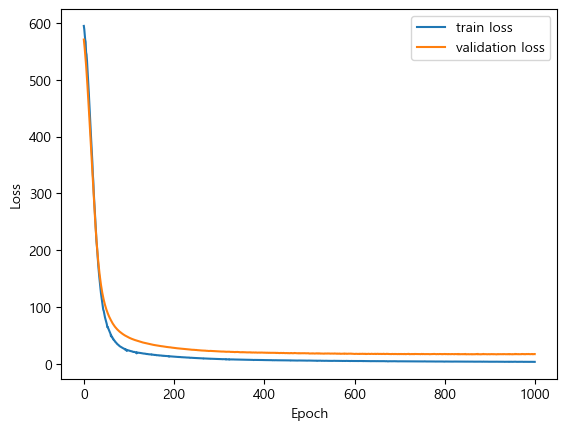

In [46]:
import matplotlib.pyplot as plt

plt.plot(range(N_EPOCH), train_loss_list, label="train loss")
plt.plot(range(N_EPOCH), val_loss_list, label="validation loss")
plt.xlabel("Epoch")
plt.ylabel('Loss')
# plt.ylim(3, 30)
plt.legend()
plt.show()

# 모델 저장

## 모델 전체 저장 및 불러오기
- 모델구조, 파라미터 저장


In [47]:
save_path = 'models/boston_model.pt'
torch.save(boston_model, save_path)

In [48]:
load_boston_model_1 = torch.load(save_path)

In [50]:
torchinfo.summary(load_boston_model_1, (200, 13))

Layer (type:depth-idx)                   Output Shape              Param #
BostonModel                              [200, 1]                  --
├─Linear: 1-1                            [200, 32]                 448
├─Linear: 1-2                            [200, 16]                 528
├─Linear: 1-3                            [200, 1]                  17
Total params: 993
Trainable params: 993
Non-trainable params: 0
Total mult-adds (M): 0.20
Input size (MB): 0.01
Forward/backward pass size (MB): 0.08
Params size (MB): 0.00
Estimated Total Size (MB): 0.09

In [51]:
val_loss = 0.0
load_boston_model_1.to(device)
load_boston_model_1.eval()
with torch.no_grad():
    for X_val, y_val in boston_test_loader:
        X_val, y_val = X_val.to(device), y_val.to(device)
        # 1.추정
        pred_val = load_boston_model_1(X_val)
        # 2. loss 계산
        val_loss += loss_fn(pred_val, y_val).item()
    val_loss /= len(boston_test_loader)

In [52]:
val_loss

17.74675178527832

## state_dict 저장 및 로딩
- 모델 파라미터만 저장

In [55]:
save_path2 = "models/boston_state_dict.pt"
model_sd = boston_model.state_dict()

torch.save(model_sd, save_path2)

In [60]:
#state_dict 를 로딩 
## 1. 모델객체 생성
load_boston_model_2 = BostonModel().to(device)
## 2. state_dict 불러오기
load_sd = torch.load(save_path2)
## 3. 불러온 state_dict(파라미터들)을 모델에 덮어 씌우기
load_boston_model_2.load_state_dict(load_sd)

<All keys matched successfully>

In [61]:
val_loss = 0.0
load_boston_model_2.to(device)
load_boston_model_2.eval() #평가모드 변환
with torch.no_grad():
    for X_val, y_val in boston_test_loader:
        X_val, y_val = X_val.to(device), y_val.to(device)
        # 1.추정
        pred_val = load_boston_model_2(X_val)
        # 2. loss 계산
        val_loss += loss_fn(pred_val, y_val).item()
    val_loss /= len(boston_test_loader)
    
val_loss    

17.74675178527832

# 분류 (Classification)

## Fashion MNIST Dataset - 다중분류(Multi-Class Classification) 문제

10개의 범주(category)와 70,000개의 흑백 이미지로 구성된 [패션 MNIST](https://github.com/zalandoresearch/fashion-mnist) 데이터셋. 
이미지는 해상도(28x28 픽셀)가 낮고 다음처럼 개별 의류 품목을 나타낸다:

<table>
  <tr><td>
    <img src="https://tensorflow.org/images/fashion-mnist-sprite.png"
         alt="Fashion MNIST sprite"  width="600">
  </td></tr>
  <tr><td align="center">
    <b>그림</b> <a href="https://github.com/zalandoresearch/fashion-mnist">패션-MNIST 샘플</a> (Zalando, MIT License).<br/>&nbsp;
  </td></tr>
</table>

이미지는 28x28 크기이며 Gray scale이다. *레이블*(label)은 0에서 9까지의 정수 배열이다. 아래 표는 이미지에 있는 의류의 **클래스**(class)들이다.

<table>
  <tr>
    <th>레이블</th>
    <th>클래스</th>
  </tr>
  <tr>
    <td>0</td>
    <td>T-shirt/top</td>
  </tr>
  <tr>
    <td>1</td>
    <td>Trousers</td>
  </tr>
    <tr>
    <td>2</td>
    <td>Pullover</td>
  </tr>
    <tr>
    <td>3</td>
    <td>Dress</td>
  </tr>
    <tr>
    <td>4</td>
    <td>Coat</td>
  </tr>
    <tr>
    <td>5</td>
    <td>Sandal</td>
  </tr>
    <tr>
    <td>6</td>
    <td>Shirt</td>
  </tr>
    <tr>
    <td>7</td>
    <td>Sneaker</td>
  </tr>
    <tr>
    <td>8</td>
    <td>Bag</td>
  </tr>
    <tr>
    <td>9</td>
    <td>Ankle boot</td>
  </tr>
</table>

In [3]:
index_to_class = np.array(['T-shirt/top', 'Trousers', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'])
class_to_index = {key:value for value, key in enumerate(index_to_class)}

index_to_class[[3, 2, 5]], class_to_index['Pullover']

(array(['Dress', 'Pullover', 'Sandal'], dtype='<U11'), 2)

In [4]:
from torchvision import transforms, datasets

In [10]:
transform = transforms.Compose([
    transforms.ToTensor(), # channel first 처리. 0 ~ 1 scaling, torch.Tensor 변환
#     transforms.Normalize(mean=0.5, std=0.5)  # 표준화((pixcel-mean)/std). (-1 ~ 1)
])
# Dataset loading
fmnist_trainset = datasets.FashionMNIST(root="datasets", train=True, 
                                        download=True, transform=transform)
fmnist_testset = datasets.FashionMNIST(root="datasets", train=False,
                                       download=True, transform=transform)

In [6]:
print(fmnist_trainset)
print(fmnist_testset)

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: datasets
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=0.5, std=0.5)
           )
Dataset FashionMNIST
    Number of datapoints: 10000
    Root location: datasets
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=0.5, std=0.5)
           )


In [7]:
len(fmnist_trainset), len(fmnist_testset)

(60000, 10000)

In [8]:
fmnist_trainset.classes

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [9]:
fmnist_trainset.class_to_idx

{'T-shirt/top': 0,
 'Trouser': 1,
 'Pullover': 2,
 'Dress': 3,
 'Coat': 4,
 'Sandal': 5,
 'Shirt': 6,
 'Sneaker': 7,
 'Bag': 8,
 'Ankle boot': 9}

In [15]:
x, y = fmnist_trainset[0]
print(y, index_to_class[y])
print(x.shape)

9 Ankle boot
torch.Size([1, 28, 28])


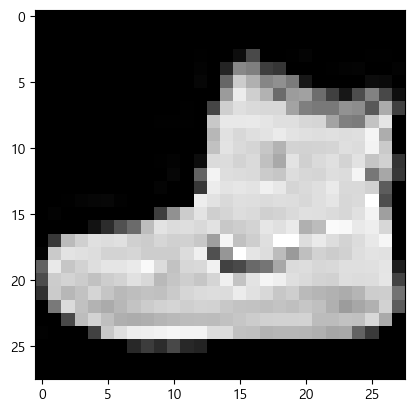

In [14]:
plt.imshow(x[0], cmap="gray")
plt.show()

In [16]:
## DataLoader 생성
fmnist_train_loader = DataLoader(fmnist_trainset, batch_size=128, 
                                 shuffle=True, drop_last=True)
fmnist_test_loader = DataLoader(fmnist_testset, batch_size=128)

In [20]:
# 모델 정의
class FashionMNISTModel(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.lr1 = nn.Linear(28*28, 2048)
        self.lr2 = nn.Linear(2048, 1024)
        self.lr3 = nn.Linear(1024, 512)
        self.lr4 = nn.Linear(512, 256)
        self.lr5 = nn.Linear(256, 128)
        self.lr6 = nn.Linear(128, 64)
        self.output = nn.Linear(64, 10) #out_feature: 10 - 10개 class별 확률.
    def forward(self, X):
        out = nn.Flatten()(X)
        out = nn.ReLU()(self.lr1(out))
        out = nn.ReLU()(self.lr2(out))
        out = nn.ReLU()(self.lr3(out))
        out = nn.ReLU()(self.lr4(out))
        out = nn.ReLU()(self.lr5(out))
        out = nn.ReLU()(self.lr6(out))
        out = self.output(out)
#         nn.Softmax()(out)
        # 다중분류의 output는 Softmax()함수로 계산해서 확률로 만들어서 출력해야 한다.
        # 모델에서는 Linear를 통과한 결과를 반환.
        # loss함수인 CrossEntropyLoss() 에서 softmax를 적용한다. 
        return out

In [21]:
f_model = FashionMNISTModel()
f_model

FashionMNISTModel(
  (lr1): Linear(in_features=784, out_features=2048, bias=True)
  (lr2): Linear(in_features=2048, out_features=1024, bias=True)
  (lr3): Linear(in_features=1024, out_features=512, bias=True)
  (lr4): Linear(in_features=512, out_features=256, bias=True)
  (lr5): Linear(in_features=256, out_features=128, bias=True)
  (lr6): Linear(in_features=128, out_features=64, bias=True)
  (output): Linear(in_features=64, out_features=10, bias=True)
)

In [22]:
torchinfo.summary(f_model, (128, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
FashionMNISTModel                        [128, 10]                 --
├─Linear: 1-1                            [128, 2048]               1,607,680
├─Linear: 1-2                            [128, 1024]               2,098,176
├─Linear: 1-3                            [128, 512]                524,800
├─Linear: 1-4                            [128, 256]                131,328
├─Linear: 1-5                            [128, 128]                32,896
├─Linear: 1-6                            [128, 64]                 8,256
├─Linear: 1-7                            [128, 10]                 650
Total params: 4,403,786
Trainable params: 4,403,786
Non-trainable params: 0
Total mult-adds (M): 563.68
Input size (MB): 0.40
Forward/backward pass size (MB): 4.14
Params size (MB): 17.62
Estimated Total Size (MB): 22.16

In [29]:
# 추정
i = torch.ones((2, 1, 28, 28), dtype=torch.float32)
# i.shape
y_hat = f_model(i)
print(y_hat.shape)
print(y_hat[0])
print(y_hat[0].sum().item(), y_hat[0].argmax(dim=-1).item())

torch.Size([2, 10])
tensor([-0.0953, -0.0415, -0.1023, -0.0777,  0.0733, -0.0241,  0.0092,  0.0143,
         0.0351, -0.0144], grad_fn=<SelectBackward0>)
-0.2233768105506897 4


In [33]:
# 모델이 추정한 결과의 class를 알고 싶을 경우는 Softmax를 계산할 필요 없다.
# 모델의 추정 확률을 알고 싶을 경우 softmax를 계산한다.
y_hat2 = nn.Softmax(dim=-1)(y_hat[0])
print(y_hat2)
print(y_hat2.sum().item(), y_hat2.argmax(dim=-1).item())

tensor([0.0928, 0.0980, 0.0922, 0.0945, 0.1099, 0.0997, 0.1031, 0.1036, 0.1058,
        0.1006], grad_fn=<SoftmaxBackward0>)
0.9999998807907104 4


In [ ]:
#### 학습
import time

# 모델 생성 + device 이동
fmnist_model = FashionMNISTModel().to(device)
# loss -> 다중분류: CrossEntropyLoss()
loss_fn = nn.CrossEntropyLoss()
# optimizer
optimzer = torch.optim.Adam(fmnist_model.parameters(), lr=0.001)

# 결과저장할 리스트
train_loss_list = []
val_loss_list = []
val_acc_list = []

## 위스콘신 유방암 데이터셋 - 이진분류(Binary Classification) 문제

- **이진 분류 문제 처리 모델의 두가지 방법**
    1. positive(1)일 확률을 출력하도록 구현
        - output layer: units=1, activation='sigmoid'
        - loss: binary_crossentropy
    2. negative(0)일 확률과 positive(1)일 확률을 출력하도록 구현 => 다중분류 처리 방식으로 해결
        - output layer: units=2, activation='softmax', y(정답)은 one hot encoding 처리
        - loss: categorical_crossentropy
        
- 위스콘신 대학교에서 제공한 종양의 악성/양성여부 분류를 위한 데이터셋
- Feature
    - 종양에 대한 다양한 측정값들
- Target의 class
    - 0 - malignant(악성종양)
    - 1 - benign(양성종양)